# CHIPPR

This notebook demonstrates the use of the Cosmological Hierarchical Inference with Probabilistic Photometric Redshifts (CHIPPR) package to estimate the redshift density function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import cProfile, pstats, StringIO

import chippr
from chippr import *

/Users/aimalz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
#help(chippr)

## Simulation

In [2]:
tru_amps = np.array([0.20, 0.35, 0.55])
tru_means = np.array([0.5, 0.2, 0.75])
tru_sigmas = np.array([0.4, 0.2, 0.1])

tru_nz = gmix(tru_amps, tru_means, tru_sigmas, limits=(0., 1.))

In [3]:
N =10**4 #2**16

tru_zs = tru_nz.sample(N)

# plt.hist(tru_zs, bins=50, normed=1)
# plt.xlabel(r'true $z$')
# plt.ylabel(r'probability density')

In [4]:
params = 'params.txt'
params = sim_utils.ingest(params)
print(params)

{'constant_sigma': ['0.05'], 'outlier_fraction': ['0.2'], 'variable_sigmas': ['0'], 'catastrophic_outliers': ['0'], 'outlier_mean': ['0.4'], 'outlier_sigma': ['0.075']}


In [5]:
bin_ends = np.array([0., 1.])
weights = np.array([1.])

int_prior = discrete(bin_ends, weights)

{'constant_sigma': 0.05, 'outlier_fraction': 0.2, 'variable_sigma': 0, 'variable_sigmas': ['0'], 'catastrophic_outliers': '0', 'outlier_mean': 0.4, 'outlier_sigma': 0.075}
         999172 function calls (995022 primitive calls) in 4.499 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       21    1.436    0.068    1.436    0.068 {built-in method poll}
   112015    0.564    0.000    0.564    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    10001    0.440    0.000    1.595    0.000 build/bdist.macosx-10.6-x86_64/egg/chippr/catalog.py:74(coarsify)
   110011    0.359    0.000    1.102    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:1743(sum)
        1    0.133    0.133    4.497    4.497 build/bdist.macosx-10.6-x86_64/egg/chippr/catalog.py:94(create)
   110012    0.113    0.000    0.663    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:31(_sum)
   121983 

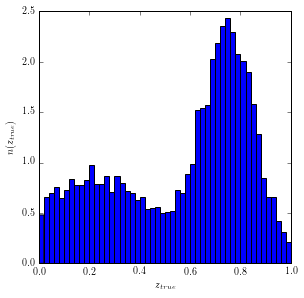

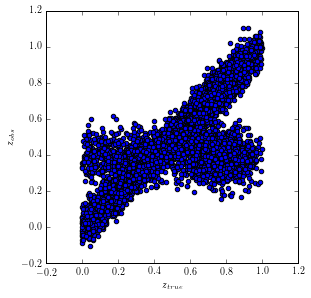

In [6]:
n_bins = 10

pr = cProfile.Profile()
pr.enable()

posteriors = catalog(params)
output = posteriors.create(tru_zs, int_prior, bins=n_bins)

data = np.exp(output['log_interim_posteriors'])

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

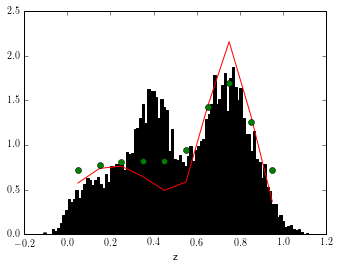

In [29]:
plt.hist(posteriors.obs_samps, bins=100, normed=True, color="k")
plt.plot(posteriors.x_coarse, tru_nz.evaluate(posteriors.x_coarse), "r-")
plt.plot(posteriors.x_coarse, np.sum(data, axis=0) / N, "go")
plt.xlabel("z")

In [ ]:
for n, z in enumerate(data[:10]):
    plt.plot(posteriors.x_coarse, data[n], 'ko')
    plt.plot(posteriors.x_fine, posteriors.obs_lfs[n], 'k-')
    plt.show()

In [ ]:
saved_location = 'data.txt'
posteriors.write(saved_location)

## Inference

In [ ]:
saved_location = 'data.txt'
simulated_posteriors = catalog()
data = simulated_posteriors.read(saved_location)

In [ ]:
zs = data['bin_ends']
nz_intp = np.exp(data['log_interim_prior'])
z_posts = np.exp(data['log_interim_posteriors'])

z_difs = zs[1:]-zs[:-1]
z_mids = (zs[1:]+zs[:-1])/2.
n_bins = len(z_mids)

In [ ]:
# prior_sigma = 0.16
# prior_var = np.eye(n_bins)
# for b in range(n_bins):
#     prior_var[b] = 1. * np.exp(-0.5 * (z_mids[b] - z_mids) ** 2 / prior_sigma ** 2)
# l = 1.e-4
# prior_var = prior_var+l*np.identity(n_bins)

prior_var = np.eye(n_bins)
for k in range(n_bins):
    prior_var[k] = 1. * np.exp(-0.5 * (z_mids[k] - z_mids) ** 2 / 0.05 ** 2)

prior_mean = nz_intp
prior = mvn(prior_mean, prior_var)

In [ ]:
nz = log_z_dens(data, prior, truth=tru_nz, vb=True)

In [ ]:
nz_stacked = nz.calculate_stacked()

In [ ]:
nz_mmap = nz.calculate_mmap()

In [ ]:
nz_mexp = nz.calculate_mexp()

In [ ]:
nz_stats = nz.compare()

In [ ]:
pr = cProfile.Profile()
pr.enable()

nz_mmle = nz.calculate_mmle(nz_stacked)

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

In [ ]:
n_ivals = 2*n_bins
initial_values = prior.sample(n_ivals)

pr = cProfile.Profile()
pr.enable()

nz_samps = nz.calculate_samples(initial_values)

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

In [ ]:
nz.info['estimators'].keys()

In [ ]:
nz.plot_estimators('final_plot.png')

In [ ]:
nz.write('nz.p')

In [ ]:
nz.info = nz.read('nz.p')
print(nz)